# Grad-CAM Demo with Tensorflow

In this notebook, we look at the implementation of Grad-CAM using tensorflow for classification of Horses and Humans using Horse or Human datasets.

To run this notebook, I am using the following package versions:

* Tensorflow: 2.8.0

* OpenCV: 4.6.0

* Tensorflow datasets: 4.6.0

There might be minor variations in the code for different versions of these packages.

Also this implementation assumes some knowledge of Tensorflow Functional API and monitoring the gradient using Gradient Tape.

### Import necessary packages

In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import imgaug as ia
from imgaug import augmenters as iaa

### Download and split the dataset

In [2]:
splits = ["train[:70%]", "train[70%:85%]", "train[85%:]"]

# load the dataset given the splits defined above
splits, info = tfds.load("horses_or_humans", with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits["train"].num_examples
num_classes = info.features["label"].num_classes

The details of the dataset and the split can be visualized using the info variable

In [3]:
info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path='~\\tensorflow_datasets\\horses_or_humans\\3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

# Resize the image and normalize the pixel values
def format_image(image, label):
    """
       Function to resize the image and normalise the pixel_values
    """
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

# Prepare training, test and validation batches
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(format_image).batch(1)


### Define the Model 

We will be using a pre-trained VGG16 network as out base model for the classifier. We use this along with a global average pooling layer and a Dense layer with softmax activation for the output. For ease of use, we will freeze the earlier layers of the VGG16 netowrk and fine tune only the final layers but you can try it out without freezing the layers as well.

In [5]:
def build_model():
    """
       Define the model architecture here
    """
    # load the base model
    base_model = vgg16.VGG16(input_shape=IMAGE_SIZE + (3,),
                           weights="imagenet",
                           include_top=False)
  
    # Freezing the earlier layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Adding a Global Average Pooling layer
    output = layers.GlobalAveragePooling2D()(base_model.output)

    # Define the outputs
    output = layers.Dense(2, activation="softmax")(output)
    # Set the inputs and outputs of the model in using Tf Functional API syntax
    model = Model(base_model.input, output)
    # Initalize the optimizer
    optimizer = tf.keras.optimizers.RMSprop(0.001)  
    # Complile the model
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
  
    # Display the model summary
    model.summary()

    return model

### Train the model

In [6]:
model = build_model()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [7]:
EPOCHS = 3
model.fit(train_batches,
          epochs=EPOCHS,
          validation_data=validation_batches)

Epoch 1/3
23/23 [==============================] - 96s 4s/step - loss: 23.8724 - accuracy: 0.5049 - val_loss: 0.6864 - val_accuracy: 0.5260
Epoch 2/3
23/23 [==============================] - 95s 4s/step - loss: 0.6845 - accuracy: 0.5313 - val_loss: 0.5985 - val_accuracy: 0.5325
Epoch 3/3
23/23 [==============================] - 97s 4s/step - loss: 0.6149 - accuracy: 0.7344 - val_loss: 0.3481 - val_accuracy: 0.8377


### Grad-CAM

Select the areas you want to visualize

In [8]:
# Select all the layers for which you want visualize the outputs
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


Now we define a function for extracting and visualizing the gradient weighed features.

If predicted class is horse, class label is 0 and prediction probability should be close to 0

If predicted class is human, class label is 1 and prediction probability should be close to 1

In [9]:
def get_CAM(processed_image, actual_label, layer_name='block5_conv3'):
    """
       Function for grad cam implementation
    """
    model_grad = Model([model.inputs],
                     [model.get_layer(layer_name).output, model.output])
  
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # Monitor the conv_output_values using gradient tape
        tape.watch(conv_output_values)
        pred_prob = predictions[:,1]

        # Typecast label to float to match the datatype of the rest of loss calculation
        actual_label = tf.cast(actual_label, dtype=tf.float32)

        # add a tiny value to avoid log of 0
        smoothing = 0.00001

        # Calculate loss as binary cross entropy loss
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")

    # Get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0, 1, 2))

    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()

    # Weight the convolution outputs with the computed gradients
    for i in range(512):
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()

    del model_grad, conv_output_values, grads_values, loss

    return heatmap

In [10]:
def show_sample(idx=None):
    """
    Visualization function. idx=None sets the image index as random
    """
    if idx:
        for img, label in test_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]
    else:
        for img, label in test_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]
  
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    activations = vis_model.predict(sample_image_processed)
 
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

    sample_activation = activations[0][0,:,:,16]

    sample_activation -= sample_activation.mean()
    sample_activation /= sample_activation.std()

    sample_activation *= 255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)

    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap * 255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_image = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_image, 0.8, heatmap.astype("float32"), 2e-3, 0.0)

    f, ax = plt.subplots(2, 2, figsize=(15, 8))

    ax[0, 0].imshow(sample_image)
    ax[0, 0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0, 0].axis("off")

    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
  
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
  
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')

    plt.tight_layout()
    plt.show()

    return activations


binary loss: [0.04127567]


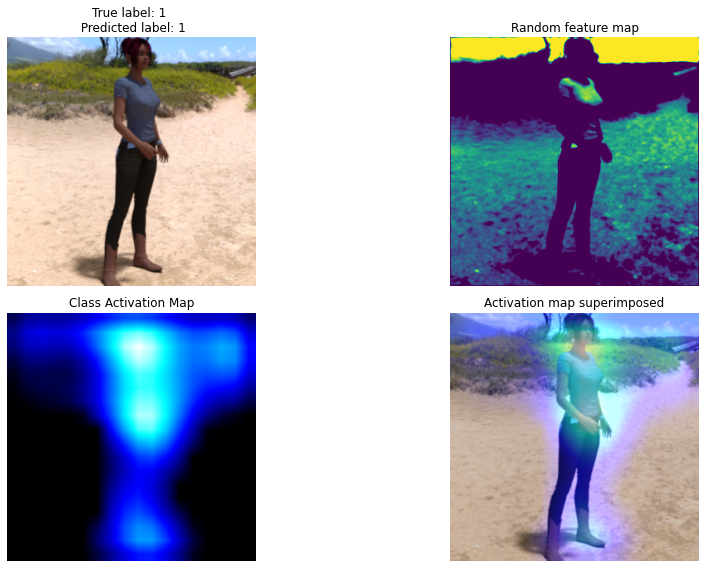

In [13]:
# Choose an image index to show, or leave it as None to get a random image
activations = show_sample(idx=6)